<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



In [ ]:
using_colab = True

In [ ]:
!git clone https://github.com/OpenGVLab/SAM-Med2D.git SAM_Med2D
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

else:
    # not sure for this part! Please check!
    !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
    !pip install opencv-python matplotlib
    # !pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Cloning into 'SAM_Med2D'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 111 (delta 42), reused 45 (delta 9), pack-reused 0
Receiving objects: 100% (111/111), 26.80 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (42/42), done.
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lfeo06av
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lfeo06av
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


# Download Weight
edit from [samed colab](https://colab.research.google.com/drive/1KCS5ulpZasYl9DgJJn59WsGEB8vwSI_m?usp=sharing#scrollTo=NI9jWQnsPty2)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

ROOT_DIR = '.'
CODE_DIR = f"{ROOT_DIR}/SAM_Med2D"
MODEL_DIR = f"{CODE_DIR}/pretrain_model"
os.makedirs(f'{MODEL_DIR}')

download_with_pydrive = True

class Downloader(object):
  def __init__(self, use_pydrive, save_dir='.'):
    self.use_pydrive = use_pydrive
    current_directory = os.getcwd()
    self.save_dir = save_dir
    if self.use_pydrive:
      self.authenticate()

  def authenticate(self):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    self.drive = GoogleDrive(gauth)

  def download_file(self, file_id, file_name):
    file_dst = f'{self.save_dir}/{file_name}'
    if os.path.exists(file_dst):
      print(f'{file_name} already exists')
      return
    downloaded = self.drive.CreateFile({'id': file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(file_dst)

downloader = Downloader(download_with_pydrive, MODEL_DIR)

sam_med2d_model = {'id': '1ARiB5RkSsWmAB_8mqWnwDF8ZKTtFwsjl', 'name': 'sam-med2d_b.pth'}
# samed_model = {'id': '1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr', 'name': 'epoch_159.pth'}
# medsam_model = {'id': '1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_', 'name': 'medsam_vit_b.pth'}
downloader.download_file(file_id=sam_med2d_model['id'], file_name=sam_med2d_model['name'])
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P $MODEL_DIR
# downloader.download_file(file_id=medsam_model['id'], file_name=medsam_model['name'])
# downloader.download_file(file_id=samed_model['id'], file_name=samed_model['name'])


# SAM-Med2D generates predicted object masks based on prompts.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append(ROOT_DIR) # make sure the import SAM_Med2D.segment_anything work

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Example image

In [ ]:
os.chdir(f'{CODE_DIR}')
image = cv2.imread('data_demo/images/amos_0507_31.png')
image.shape

(290, 320, 3)

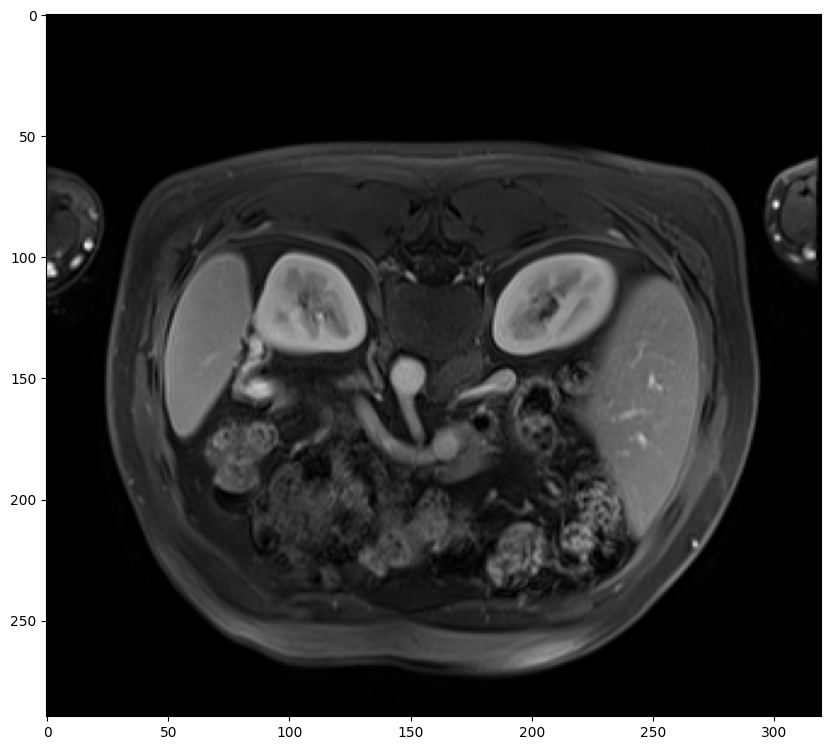

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

## Load SAM-Med2D model

In [ ]:
from SAM_Med2D.segment_anything import sam_model_registry
from SAM_Med2D.segment_anything.predictor_sammed import SammedPredictor
from argparse import Namespace
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "pretrain_model/sam-med2d_b.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load pretrain_model/sam-med2d_b.pth


Process the image to produce an image embedding by calling `SammedPredictor.set_image`. `SammedPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
predictor.set_image(image)

## Specifying a specific object with a point

In [ ]:
ori_h, ori_w, _ = image.shape
input_point = np.array([[162, 127]])
input_label = np.array([1])

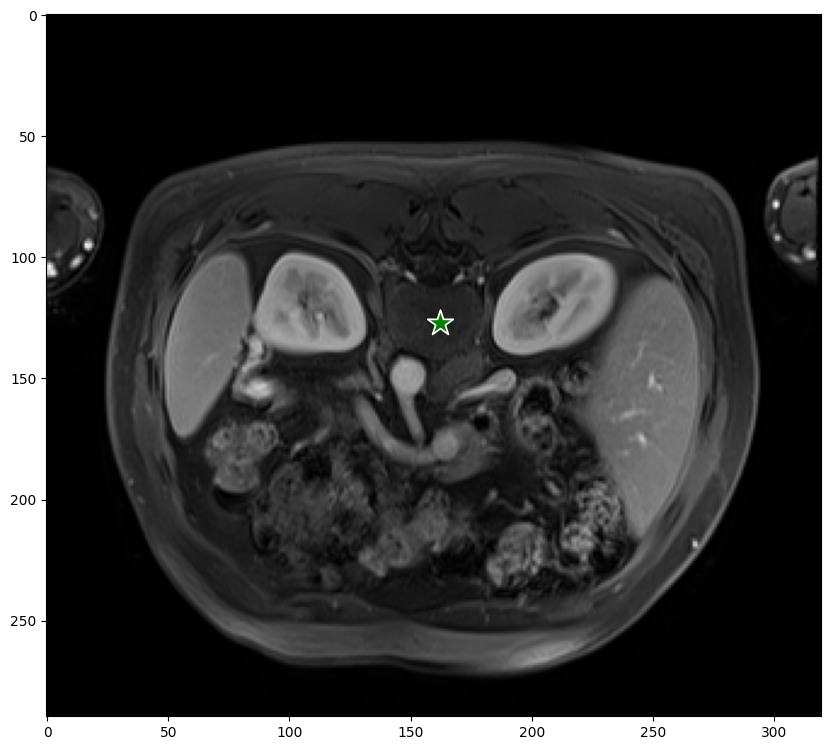

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(1, 290, 320)

Predict with `SammedPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

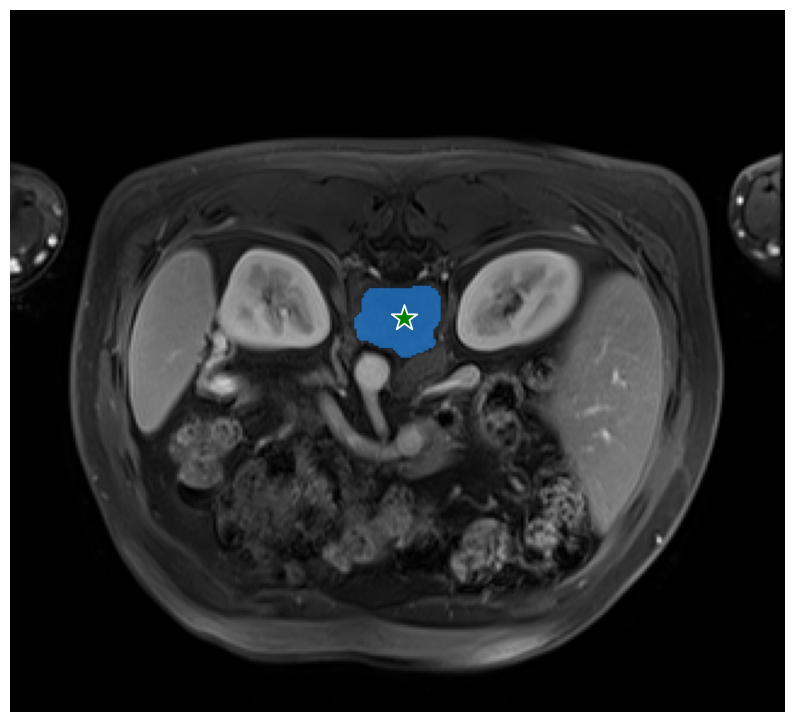

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


## Optimizing Segmentation Results by Point Interaction

In [ ]:
input_point1 = np.array([[169, 140]])
input_label1 = np.array([0])
input_points = np.concatenate((input_point, input_point1))
input_labels = np.concatenate((input_label, input_label1))
mask_inputs = torch.sigmoid(torch.as_tensor(logits, dtype=torch.float, device=device))

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input = mask_inputs,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W

(1, 290, 320)

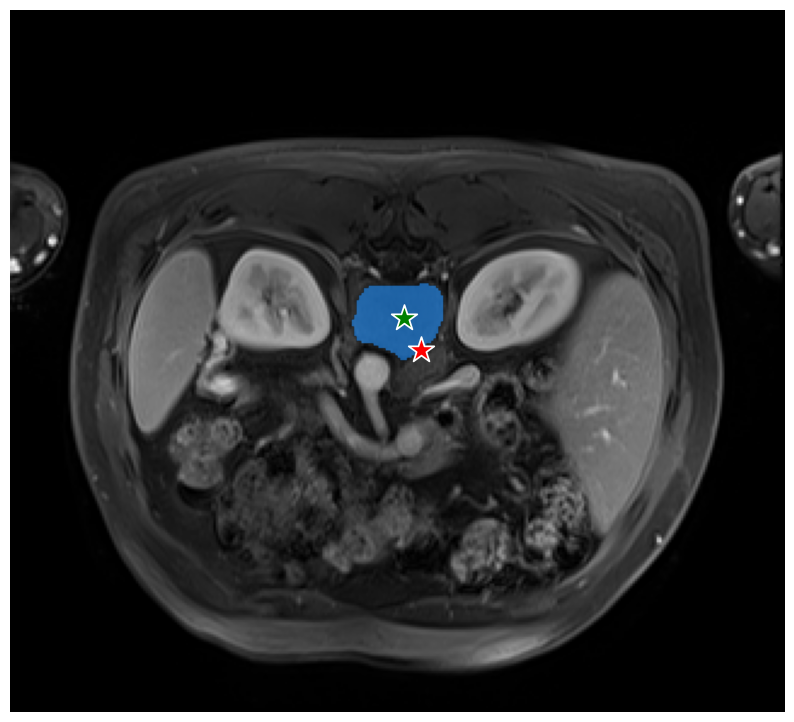

In [ ]:

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()

## Specifying a specific object with a bounding box

The model can also take a box as input, provided in xyxy format.

In [ ]:
image = cv2.imread('data_demo/images/s0114_111.png')
predictor.set_image(image)
input_box = np.array([89,43,113,64]) #

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=True,
)

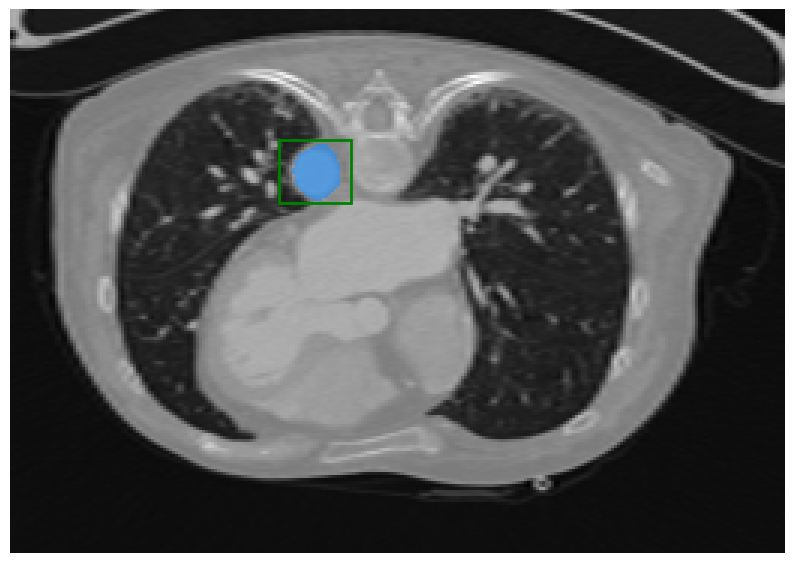

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Multiple bounding box prediction results

In [ ]:
input_boxes = torch.tensor([[72,110,136,143],[124,92,160,132]], device=predictor.device)

In [ ]:
transformed_boxes = predictor.apply_boxes_torch(input_boxes, image.shape[:2], (args.image_size, args.image_size))
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=True,
)
print(transformed_boxes.shape)
print(masks.shape)  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([2, 4])
torch.Size([2, 1, 181, 258])


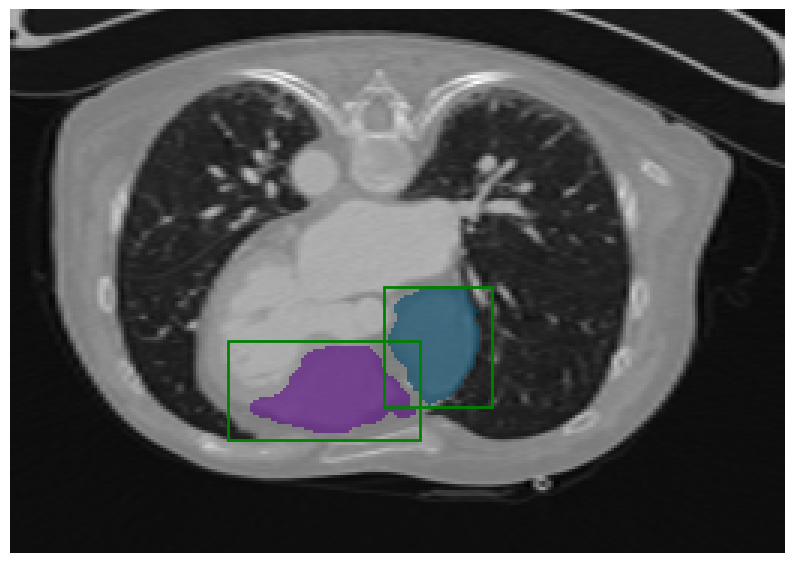

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

